In [2]:
import pandas as pd
import psycopg2
import psycopg2.extras as extras # for bulk insert
import os
import io 

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')
]

# Connect to PostgreSQL database 
# 'your_host', 'your_username', 'your_password', 'your_database' 
try:
    conn = psycopg2.connect(
        host='localhost',
        user='postgres',
        password='1234',
        dbname='Ecommerce'
    )
    conn.autocommit = False # Transaction control 
except Exception as error:
    print(f"PostgreSQL connection error: {error}")
    exit()

cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\mtr\Desktop\Ecommerce'

# ---
## PostgreSQL data type mapping

def get_sql_type_postgres(dtype):
    """Pandas dtype को PostgreSQL SQL type में बदलता है।"""
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT8'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TIMESTAMP'
    else:
        return 'TEXT'



for csv_file, table_name in csv_files:
    file_path = os.path.join(r"C:\Users\mtr\Desktop\Ecommerce", csv_file)
    
    print(f"Processing {csv_file} into table {table_name}...")
    
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}. Skipping.")
        continue

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Clean column names 
    # we are converting columns into lower case with underscore seprater !!
    df.columns = [col.strip().lower().replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'"{col}" {get_sql_type_postgres(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS "{table_name}" ({columns})'
    
    try:
        cursor.execute(create_table_query)
        print(f"Table {table_name} created or already exists.")

        # --- Bulk Insertion using execute_values for better performance ---
        
        # Converting DataFrame into list and tuples(for Bulk insert)
        tuples = [tuple(x) for x in df.values]
        
        # Column names is formating by double qoutes
        cols = ', '.join([f'"{c}"' for c in df.columns])
        
        # Insert query
        insert_query = f"INSERT INTO \"{table_name}\" ({cols}) VALUES %s"
        
        # use execute_values for bulk insertion 
        extras.execute_values(cursor, insert_query, tuples, page_size=1000)

        # Commit the transaction for the current CSV file
        conn.commit()
        print(f"Data from {csv_file} successfully inserted into {table_name}. Rows inserted: {len(df)}\n")

    except (Exception, psycopg2.DatabaseError) as error:
        print(f"Error processing {csv_file}: {error}")
        conn.rollback() # rollback if error occures
        
# Close the connection
cursor.close()
conn.close()
print("Database connection closed.")

Processing customers.csv into table customers...
Table customers created or already exists.
Data from customers.csv successfully inserted into customers. Rows inserted: 99441

Processing orders.csv into table orders...
Table orders created or already exists.
Data from orders.csv successfully inserted into orders. Rows inserted: 99441

Processing sellers.csv into table sellers...
Table sellers created or already exists.
Data from sellers.csv successfully inserted into sellers. Rows inserted: 3095

Processing products.csv into table products...
Table products created or already exists.
Data from products.csv successfully inserted into products. Rows inserted: 32951

Processing geolocation.csv into table geolocation...
Table geolocation created or already exists.
Data from geolocation.csv successfully inserted into geolocation. Rows inserted: 1000163

Processing payments.csv into table payments...
Table payments created or already exists.
Data from payments.csv successfully inserted into 

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 
import psycopg2.extras as extras 


conn = psycopg2.connect(
        host='localhost',
        user='postgres',
        password='1234',
        dbname='Ecommerce')

cur = conn.cursor()
print("Connect sucssesfull !!")

Connect sucssesfull !!


# Basics Queries 
# 1. List all unique cities where customers are located

In [3]:
query=''' select distinct customer_city from customers '''
cur.execute(query)
data = cur.fetchall()
data


[('abadia dos dourados',),
 ('abadiania',),
 ('abaete',),
 ('abaetetuba',),
 ('abaiara',),
 ('abaira',),
 ('abare',),
 ('abatia',),
 ('abdon batista',),
 ('abelardo luz',),
 ('abrantes',),
 ('abre campo',),
 ('abreu e lima',),
 ('acaiaca',),
 ('acailandia',),
 ('acajutiba',),
 ('acarau',),
 ('acari',),
 ('acegua',),
 ('acopiara',),
 ('acreuna',),
 ('acu',),
 ('acucena',),
 ('adamantina',),
 ('adhemar de barros',),
 ('adolfo',),
 ('adrianopolis',),
 ('adustina',),
 ('afogados da ingazeira',),
 ('afonso claudio',),
 ('afranio',),
 ('agisse',),
 ('agrestina',),
 ('agrolandia',),
 ('agronomica',),
 ('agua boa',),
 ('agua branca',),
 ('agua clara',),
 ('agua comprida',),
 ('agua doce',),
 ('agua doce do norte',),
 ('agua fria de goias',),
 ('agua limpa',),
 ('agua nova',),
 ('agua preta',),
 ('agua santa',),
 ('aguai',),
 ('aguas belas',),
 ('aguas claras',),
 ('aguas da prata',),
 ('aguas de lindoia',),
 ('aguas de santa barbara',),
 ('aguas de sao pedro',),
 ('aguas formosas',),
 ('aguas 

# 2. Count the number of orders placed in 2017


In [4]:
query=''' select count(order_id) from orders where extract(year from order_purchase_timestamp::TIMESTAMP) = 2017 '''
# conn.rollback()
cur.execute(query)
data = cur.fetchall()
print("Count the number of orders placed in 2017" ,data)



Count the number of orders placed in 2017 [(811818,)]


# 3. Find the total sales per category.

In [5]:
query='''select p.product_category,ROUND( sum(pa.payment_value)::numeric,2) as total_sales
from order_items oi  join products p  on oi.product_id = p.product_id
join payments pa on pa.order_id = oi.order_id
group by p.product_category  order by  total_sales desc '''
conn.rollback()
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=["Category","Sales"])
print(df)

                       Category          Sales
0                bed table bath  8877878225.47
1                 HEALTH BEAUTY  8591822254.04
2          computer accessories  8218353052.80
3          Furniture Decoration  7414034405.82
4               Watches present  7409059269.02
..                          ...            ...
69                     PC Gamer    11272245.12
70              House Comfort 2     8867439.36
71               cds music dvds     6217845.12
72  Fashion Children's Clothing     4072913.28
73       insurance and services     1682259.84

[74 rows x 2 columns]


# 4. Calculate the percentage of orders that were paid in installments.


In [6]:
query='''select round(((sum(payment_installments)/sum(payment_value))*100)::numeric ,2) from payments ; '''
conn.rollback()
cur.execute(query)
data = cur.fetchall()
data
print(data[0][0],"%")

1.85 %


# 5. Count the number of customers from each state. 


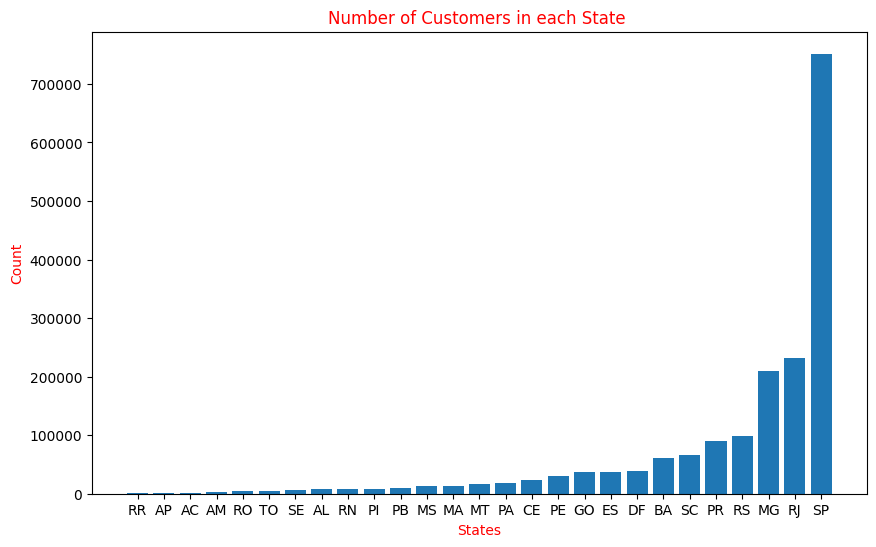

In [7]:
query=''' select customer_state, Count(customer_id) as count from customers group by customer_state  order by count ; '''
conn.rollback()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["State","Count"])


# Bar Chart  --> 
plt.figure(figsize=(10,6)) 
plt.bar(df["State"],df["Count"])
plt.xlabel("States", color="red")
plt.ylabel("Count",color="red")
plt.title("Number of Customers in each State ",color="red")
plt.show()


# Intermediate Queries
# 1. Calculate the number of orders per month in 2018.

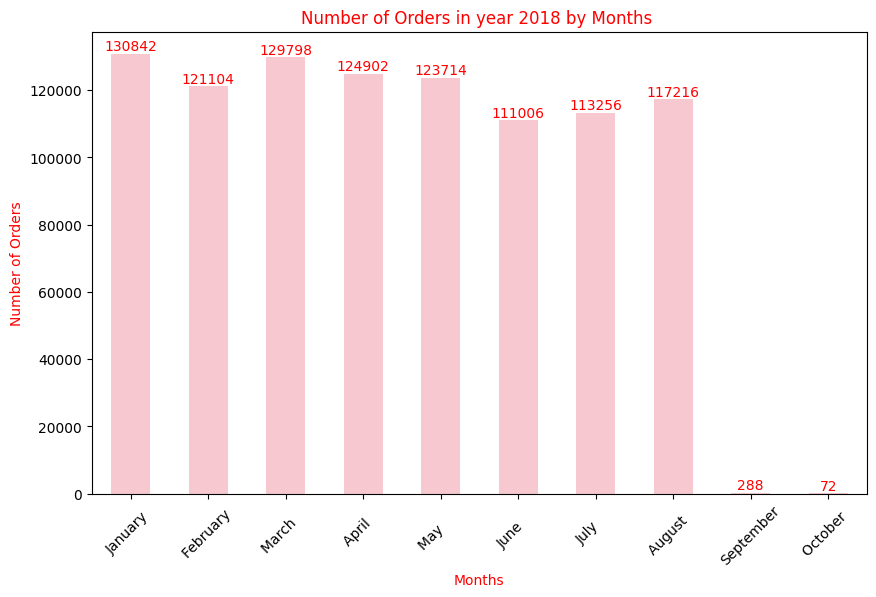

In [8]:
query=''' select to_char(order_purchase_timestamp::timestamp, 'Month') as month,
       count(order_id) as total_orders
from orders
where extract(year from order_purchase_timestamp::timestamp) = 2018
group by to_char(order_purchase_timestamp::timestamp, 'Month'),
         extract(month from order_purchase_timestamp::timestamp)
order by extract(month from order_purchase_timestamp::timestamp); '''
conn.rollback()
cur.execute(query)
data = cur.fetchall()
plt.figure(figsize=(10,6))

df=pd.DataFrame(data,columns=['Months','Number of Orders'])
# By matplotlib 
# plt.bar(df['Months'],df['Number of Orders'],color='pink',width=0.5)

#n By seaborn
bar1=sns.barplot(x=df['Months'],y=df['Number of Orders'],color='pink',width=0.5)
bar1.bar_label(bar1.containers[0],color='red')
plt.xlabel("Months", color="red")
plt.ylabel("Number of Orders",color="red")
plt.title("Number of Orders in year 2018 by Months ",color="red",)

# rotate the text or label of x axis
plt.xticks(rotation=45)


plt.show()


# 2. Calculate the percentage of total revenue contributed by each product category.


In [9]:
query=''' select p.product_category,
round(((sum(pa.payment_value) / (select sum(payment_value)  from payments))*100)::numeric,2) as percentage
from order_items oi  join products p  on oi.product_id = p.product_id
join payments pa on pa.order_id = oi.order_id
group by p.product_category ; '''
conn.rollback()
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns=["category","percentage of total revenue"])
df.head(10)

,category,percentage of total revenue
0,Agro Industria e Comercio,213.60
1,Art,55.76
2,Arts and Crafts,4.18
3,audio,108.52
4,automotive,1533.28
5,babies,971.18
6,Bags Accessories,336.69
7,bed table bath,3080.89
8,Blu Ray DVDs,14.28
9,Casa Construcao,245.83


# 3. Identify the correlation between product price and the number of times a product has been purchased by category.


In [10]:
query=''' select pr.product_category,count(pr.product_id),
       round(avg(oi.price)::numeric,2) as average
from products pr 
       join order_items oi on pr.product_id=oi.product_id
group by pr.product_category ; '''
conn.rollback()
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns =['Category','Product Count','Average'])
df

# correlation between product price and the number of times a product
arr1=df['Product Count'].astype(float)
arr2=df['Average'].astype(float)
# print(np.corrcoef([arr1,arr2]))
a=np.corrcoef([arr1,arr2])
print('correlation between product price and the number of times a product : ',a[0,1])


# Don't see diagonals but -> There is no impact on order by their price becuase the value is close to 0

correlation between product price and the number of times a product :  -0.10631625823860695


# 4. Calculate the total revenue generated by each seller, and rank them by revenue.

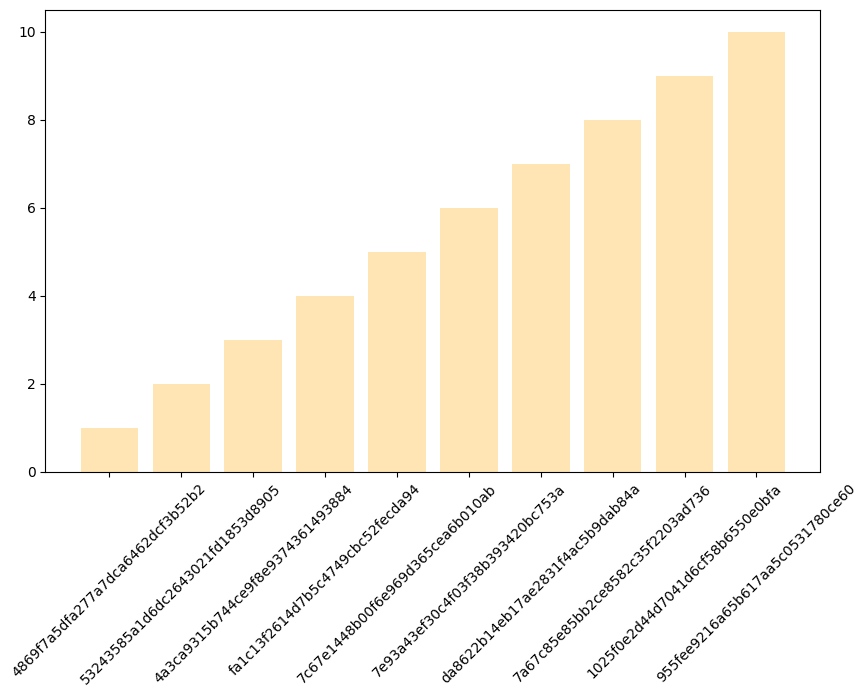

In [11]:
query='''select seller_id, round(sum(price)::numeric,2) ,dense_rank() over (order by sum(price)desc) as rank 
from order_items 
       group by seller_id;'''
# conn.rollback()
cur.execute(query)
data = cur.fetchall()


df=pd.DataFrame(data,columns =['Seller_Id','Total sales','Rank'])
plt.figure(figsize=(10,6))

# print("Top 5 sellers id are :\n" , df.head(5))
top10=df.head(10)
plt.bar(top10['Seller_Id'],top10['Rank'],color='#FFE5B4',width=0.8)
plt.xticks(rotation=45)
plt.show()


# Advance Queries !!
# 1. Calculate the cumulative sales per month for each year.


In [ ]:
query='''select year,months,sales ,sum(sales)
         over (order by year,months)
         from 
        (select extract(month from o.order_purchase_timestamp::timestamp) as months,
       extract(year from o.order_purchase_timestamp::timestamp)as year,
	   round(sum(pa.payment_value)::numeric ,2) as sales
       from orders o join payments pa  
	   on pa.order_id=o.order_id
	   group by extract(month from o.order_purchase_timestamp::timestamp),
	   extract(year from o.order_purchase_timestamp::timestamp)
	   order by  extract(year from o.order_purchase_timestamp::timestamp),
	   extract(month from o.order_purchase_timestamp::timestamp))as a;
'''
# conn.rollback()
cur.execute(query)
data = cur.fetchall()
data

df=pd.DataFrame(data,columns =['Year','Months','Sales','cumulative sales'])
df
# plt.figure(figsize=(10,6))

# 2. Calculate the year-over-year growth rate of total sales.

In [3]:
# (current - previous) / previous * 100 →  its give percent of growth
query=''' select 
    year,
    round(lag(total_sales) over (order by year)::numeric,2) as prev_year_sales,
   round((((total_sales-(lag(total_sales) over (order by year)))
	/ lag(total_sales) over (order by year) )  *100)::numeric ,2) as year_over_year_growth
from 
(select extract(year from o.order_purchase_timestamp::timestamp) as year,sum(pa.payment_value) as total_sales
from orders o join payments pa on o.order_id=pa.order_id 
group by extract(year from o.order_purchase_timestamp::timestamp))as a;
'''
# conn.rollback()
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=['Year','Prev_Year_Sales','year_over_year_growth'])
df


,Year,Prev_Year_Sales,year_over_year_growth
0,2016,None,None
1,2017,23744936.00,12112.70
2,2018,2899898692.00,20.00


# 3. Identify the top 3 customers who spent the most money in each year.

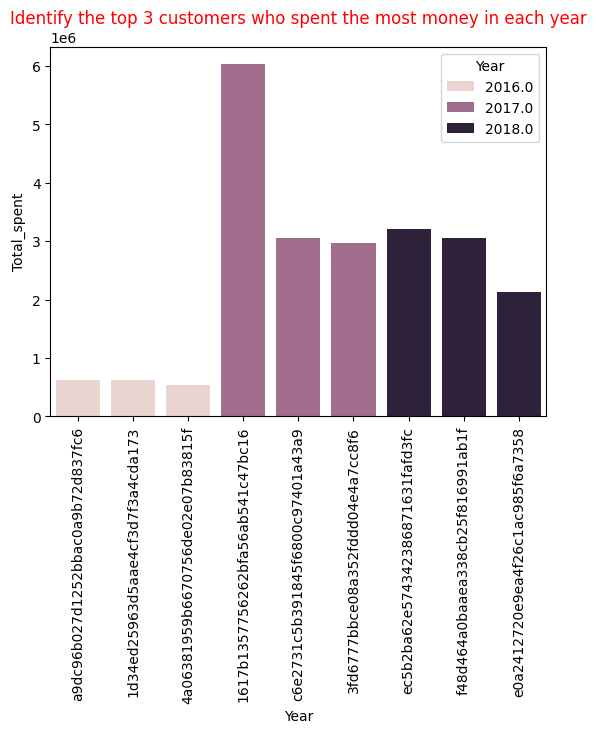

In [15]:
query=''' with ranked_customers as (
select extract(year from o.order_purchase_timestamp:: timestamp) as year,
        o.customer_id,sum(pa.payment_value) as total_spent,
  dense_rank() over ( partition by extract(year from o.order_purchase_timestamp:: timestamp)
            order by sum(pa.payment_value) desc) as rank
    from orders o
    join payments pa on o.order_id = pa.order_id
    group by year, o.customer_id)
select *
from ranked_customers
where rank <= 3
order by year, rank;
'''
# conn.rollback()
cur.execute(query)
data = cur.fetchall()
# data
df=pd.DataFrame(data,columns=['Year','Customer_id','Total_spent','Rank'])
# df
sns.barplot(x='Customer_id',y='Total_spent',data=df,hue='Year')
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Total_spent")
plt.title("Identify the top 3 customers who spent the most money in each year",color="red",)
plt.show()